In [4]:
library(deSolve)# Load libary to be used for numerical integration
library(ggplot2)

In [5]:
#Model parameters 
seirv_params <- list(
  a = 50,
  c = 30,
  beta_AA = 2,
  beta_AT = 2,
  beta_TA = 2,
  beta_TT = 2,
  gamma = 1/4,#incubation rate 
  tau = 1/365,#loss imnity rate
  delta = 1/10,#recovery rate
  nu = 1/(0.4*365),#vaccination rate
  #b = 1/(70*365),#birth rate
  epsilon = 0.1#disease death rate 
)

In [6]:
# Initial state 
N0_A = 1000#
N0_T = 1000#
flu_zero <- c(S_A = N0_A-1, E_A = 0, I_A = 1, R_A = 0, V_A = 0,
              S_T = N0_T-1, E_T = 0, I_T = 1, R_T = 0, V_T = 0)

In [12]:
# Define the control
# I intectious
# N pop size
# x
f.fn <- function(I, N, x, a = 50){
  if (I<x){
    ans <- 0.5
  }
  else{
    ans <- exp(-a*I/N)
  }
}

## Dual SEIRV model

In [8]:
seirv <- function(t, y, parms){
  with(c(as.list(y), parms), {
    N_A <- S_A + E_A + I_A + R_A + V_A
    N_T <- S_T + E_T + I_T + R_T + V_T
    N <- N_A + N_T
    I <- I_A + I_T
    #background death rate
    ##threshold
    #Transmission coefficients
    lambda_AA <- beta_AA * exp(-a*I/N) * I_A/N_A; 
    lambda_TA <- beta_TA * exp(-c*I/N) *I_T/N_T;
    lambda_TT <- beta_TT*I_T/N_T; 
    lambda_AT <- beta_AT*exp(-c*I/N)*I_A/N_A;
    #
    # risk averse
    dS_Adt <- - (nu + lambda_AA + lambda_TA)*S_A 
    dE_Adt <- (lambda_AA + lambda_TA) * S_A - gamma * E_A
    dI_Adt <- gamma * E_A - (delta + epsilon) * I_A
    dR_Adt <- delta * I_A
    dV_Adt <- nu * S_A - tau * V_A
    
    #risk tolerant
    dS_Tdt <- - ( + nu + lambda_TT + lambda_AT)*S_T
    dE_Tdt <- (lambda_TT + lambda_AT) * S_T - gamma * E_T
    dI_Tdt <- gamma * E_T - (delta + epsilon) * I_T
    dR_Tdt <- delta * I_T
    dV_Tdt <- nu * S_T - tau * V_T
    # return a list 
    return(list(c(dS_Adt, dE_Adt, dI_Adt, dR_Adt, dV_Adt, dS_Tdt, dE_Tdt, dI_Tdt, dR_Tdt, dV_Tdt)))
  })
}

## Dual SEIRV model with control

In [14]:
seirv_interv <- function(t, y, parms){
  with(c(as.list(y), parms), {
    N_A <- S_A + E_A + I_A + R_A + V_A
    N_T <- S_T + E_T + I_T + R_T + V_T
    N <- N_A + N_T
    I <- I_A + I_T
    #background death rate
    ##threshold
    x0 = N*log(2)/50#Risk averse
    y0 = N*log(2)/30#Risk tolerant
    t_inter = 10
    #Transmission coefficients
    if (t < t_inter){
        lambda_AA <- beta_AA * exp(-a*I/N) * I_A/N_A; 
        lambda_TA <- beta_TA * exp(-c*I/N) *I_T/N_T;
        lambda_TT <- beta_TT*I_T/N_T; 
        lambda_AT <- beta_AT*exp(-c*I/N)*I_A/N_A;
    }
    else{
        lambda_AA <- beta_AA * f.fn(I,N, x0, 50)* I_A/N_A; 
        lambda_TA <- beta_TA * f.fn(I,N, x0, 30)*I_T/N_T;
        lambda_TT <- beta_TT*I_T/N_T * 0.5 ; 
        lambda_AT <- beta_AT* f.fn(I,N, x0, 30)*I_A/N_A;
    }      
    #
    # risk averse
    dS_Adt <- - (nu + lambda_AA + lambda_TA)*S_A 
    dE_Adt <- (lambda_AA + lambda_TA) * S_A - gamma * E_A
    dI_Adt <- gamma * E_A - (delta + epsilon) * I_A
    dR_Adt <- delta * I_A
    dV_Adt <- nu * S_A - tau * V_A
    
    #risk tolerant
    dS_Tdt <- - ( + nu + lambda_TT + lambda_AT)*S_T
    dE_Tdt <- (lambda_TT + lambda_AT) * S_T - gamma * E_T
    dI_Tdt <- gamma * E_T - (delta + epsilon) * I_T
    dR_Tdt <- delta * I_T
    dV_Tdt <- nu * S_T - tau * V_T
    # return a list 
    return(list(c(dS_Adt, dE_Adt, dI_Adt, dR_Adt, dV_Adt, dS_Tdt, dE_Tdt, dI_Tdt, dR_Tdt, dV_Tdt)))
  })
}

## Integration

In [10]:
## This function compute the ODEs' solution
simEpidemic <- function(initial_state, timestep, model, params){
  ## Integration with
  ts <- data.frame(lsoda(
    y = initial_state,# Initial conditions for population
    times = timestep, # Timepoints for evaluation
    func = model,# Function to evaluate
    parms = params# Vector of parameters
  ))
  N = 
    ts$P <- with(ts, (I_A+I_T)/(N0_A+N0_T))
  # ts$P_T <- with(ts, I_T/N0_T)
  return(ts)
}

In [15]:
# Simulation
## Set the time
num_years <- 0.5
time.out <- seq(0, num_years*365, by=1)

ts_seirv_before_inter <- simEpidemic(flu_zero, time.out, seirv, seirv_params)

ts_seirv_inter <- simEpidemic(flu_zero, time.out, seirv_interv, seirv_params)

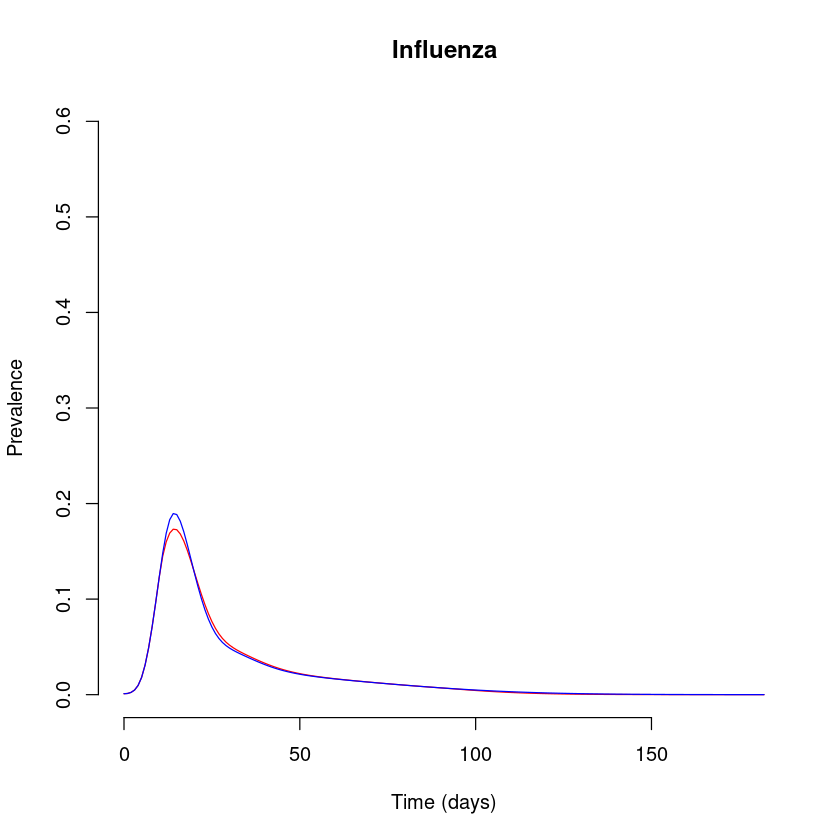

In [16]:
# Plotting ---------------------------------------------------------------------

#### Infected-----------------------------------------------
max_y <- max(c(max(ts_seirv_inter$P), max(ts_seirv_before_inter$P)))
plot(ts_seirv_inter$time,               # Time on the x axis
     ts_seirv_inter$P,                  # Number infected (I) on the y axis
     xlab = "Time (days)",     # Label the x axis
     ylab = "Prevalence",  # Label the y axis
     main = "Influenza",    # Plot title
     xlim = c(0, max(ts_seirv_inter$time)),           #
     ylim = c(0, 0.6),
     col="red",
     type = "l",                # Use a line plot
     bty = "n")                 # Remove the box around the plot
# Z <- rep(0.5, length(ts_seirv$tim))
lines(ts_seirv_inter$time, ts_seirv_before_inter$P, col="blue")
# legend("topright", legend = c("After interv", "Before interv"), col = c("red", "blue"), lwd = 2)
